In [1]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
root_path = 'gdrive/My Drive/OmdenaAI/engie/'

In [4]:
sat_images = glob.glob(root_path + 'vegas_jpeg/*.jpeg') #gives path
print(sat_images[:2], len(sat_images))

['gdrive/My Drive/OmdenaAI/engie/vegas_jpeg/4480.jpeg', 'gdrive/My Drive/OmdenaAI/engie/vegas_jpeg/122.jpeg'] 1282


In [5]:
len(sat_images)

1282

In [6]:
from tqdm import tqdm
from multiprocessing import Pool
progress = tqdm(total= len(sat_images), position=0)

def read(path):
  img = image.load_img(path, target_size=(256,256,3))
  img = image.img_to_array(img)
  #img = img[0:512, 0:512]
  img = img/255.
  progress.update(1)
  return img
p = Pool(10)
img_array = p.map(read, sat_images)

 10%|█         | 132/1282 [01:16<11:20,  1.69it/s]

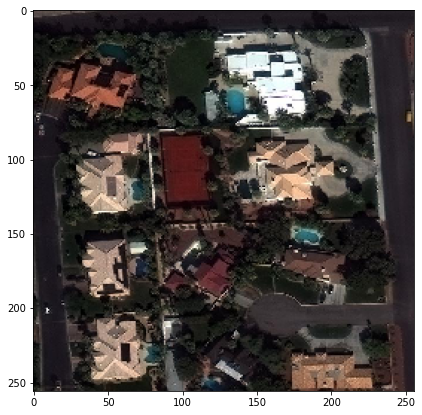

In [7]:
plt.figure(figsize=(7,7))
plt.imshow(img_array[26])

In [8]:
img_array[26].shape

(256, 256, 3)

In [9]:
all_images = np.array(img_array)

In [10]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [11]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image):
    small_image = cv2.resize(image, (100,100), interpolation = cv2.INTER_AREA)
  
  # scale back to original size
    low_res_image = cv2.resize(small_image, (256,256), interpolation = cv2.INTER_AREA)

    return low_res_image

In [12]:
train_x_px = []

for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
    temp = pixalate_image(val_x[i,:,:,:])
    val_x_px.append(temp)

val_x_px = np.array(val_x_px)

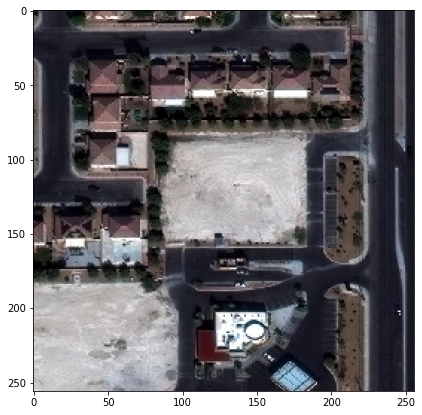

In [13]:
plt.figure(figsize=(7,7))
plt.imshow(train_x[100])

In [14]:
train_x[100].shape

(256, 256, 3)

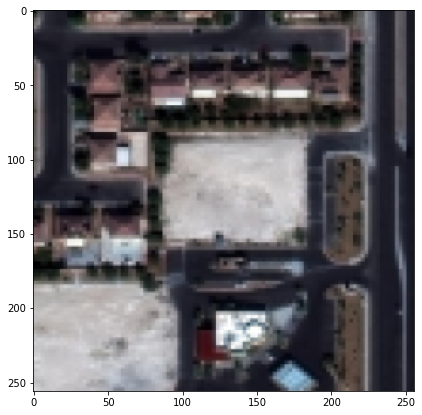

In [15]:
plt.figure(figsize=(7,7))
plt.imshow(train_x_px[100])

In [16]:
train_x_px[100].shape

(256, 256, 3)

In [17]:
#lets build the model No TPU
#with strategy.scope():
Input_img = Input(shape=(256, 256, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [18]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('super_resolution_autoencoder_checkpoint.h5',save_best_only=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [19]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
33/33 [==============================] - 16s 488ms/step - loss: 0.0593 - accuracy: 0.4569 - val_loss: 0.0524 - val_accuracy: 0.5699
Epoch 2/100
33/33 [==============================] - 16s 470ms/step - loss: 0.0301 - accuracy: 0.5233 - val_loss: 0.0084 - val_accuracy: 0.6522
Epoch 3/100
33/33 [==============================] - 16s 471ms/step - loss: 0.0076 - accuracy: 0.7193 - val_loss: 0.0071 - val_accuracy: 0.8053
Epoch 4/100
33/33 [==============================] - 15s 468ms/step - loss: 0.0070 - accuracy: 0.7960 - val_loss: 0.0072 - val_accuracy: 0.7635
Epoch 5/100
33/33 [==============================] - 16s 471ms/step - loss: 0.0069 - accuracy: 0.8287 - val_loss: 0.0067 - val_accuracy: 0.8499
Epoch 6/100
33/33 [==============================] - 16s 471ms/step - loss: 0.0067 - accuracy: 0.8826 - val_loss: 0.0066 - val_accuracy: 0.8953
Epoch 7/100
33/33 [==============================] - 16s 471ms/step - loss: 0.0065 - accuracy: 0.8954 - val_loss: 0.0064 - val_accuracy:

In [20]:
autoencoder = tf.keras.models.load_model('super_resolution_autoencoder_checkpoint.h5')

In [21]:
predictions = autoencoder.predict(val_x_px)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


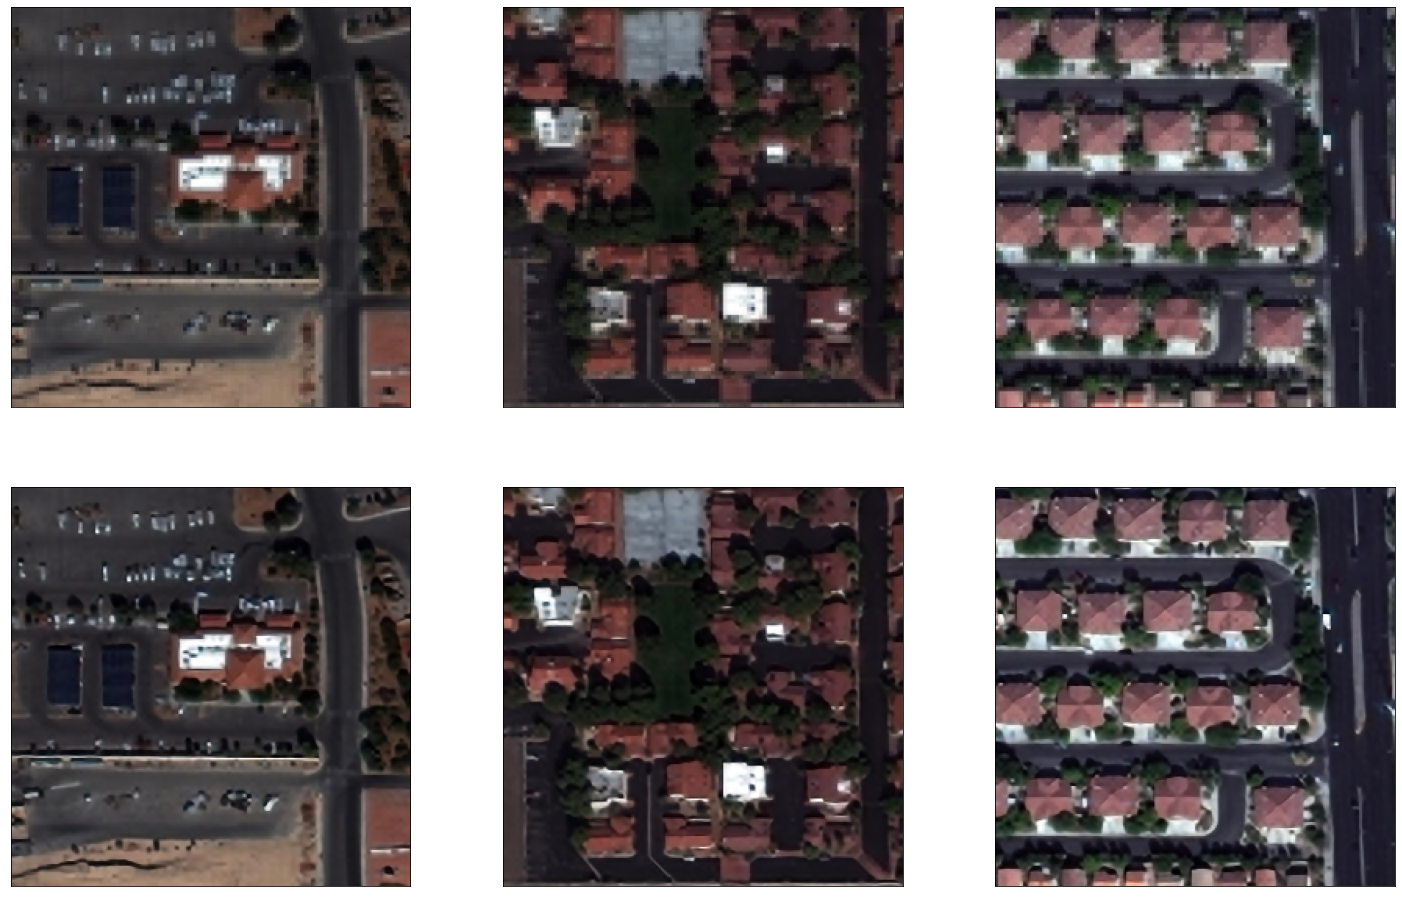

In [22]:
n = 3
plt.figure(figsize= (25,25))

for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(val_x_px[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(predictions[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
results = autoencoder.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

9/9 [==============================] - 1s 110ms/step - loss: 0.0057 - accuracy: 0.9209
loss, accuracy [0.005655055399984121, 0.9208670854568481]


In [24]:
print(root_path +'test/main_22800_10400.jpeg')

gdrive/My Drive/OmdenaAI/engie/test/main_22800_10400.jpeg


In [25]:
img = image.load_img(root_path +'test/main_22800_10400.jpeg', target_size=(256,256,3))
img = image.img_to_array(img)
img = img/255.

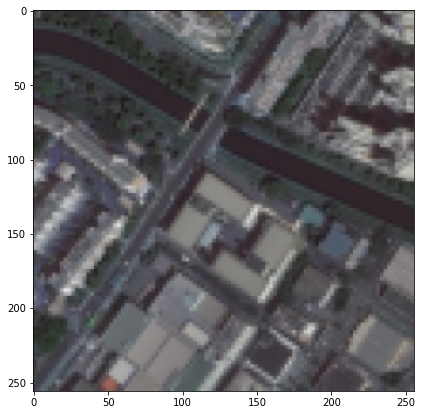

In [26]:
plt.figure(figsize=(7,7))
img = pixalate_image(img)
plt.imshow(img)

In [27]:
input_array = np.array([img])

In [28]:
predict = autoencoder.predict(input_array)

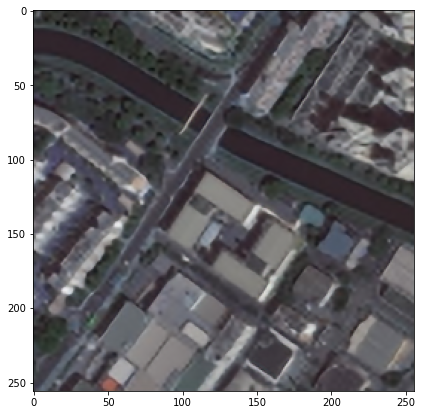

In [29]:
plt.figure(figsize=(7,7))
plt.imshow(predict[0])